### COVID-19 Analysis

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input style="background-color:blue; color: white;" type="submit" value="Click to toggle on/off source code.">
</form>''')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import geopandas as gpd
from shapely.geometry import Point

In [3]:
import base64

def create_download_link( df, title = "Download CSV file", filename = "data.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

### Sourced from John Hopkins University Currated Dataset

data source: https://docs.google.com/spreadsheets/d/1avGWWl1J19O_Zm0NGTGy2E-fOG05i4ljRfjl87P7FiA/edit?ts=5e5e9222#gid=0

Table shown is top 10 rows. You can click the download link to get all of the data.

In [5]:
raw_df = pd.read_csv('https://docs.google.com/spreadsheets/d/1avGWWl1J19O_Zm0NGTGy2E-fOG05i4ljRfjl87P7FiA/export?id=1avGWWl1J19O_Zm0NGTGy2E-fOG05i4ljRfjl87P7FiA&gid=0&format=csv', parse_dates=['Date', 'Last_Update_Date'])
raw_df['DailyCount'] = raw_df['Difference']
raw_df.head(10)

HTTPError: HTTP Error 400: Bad Request

In [5]:
df = raw_df[['Country/Region','Date','Case_Type', 'DailyCount']]
df = df.groupby(['Country/Region','Date' ,'Case_Type']).sum()
df = df.reset_index()

NameError: name 'raw_df' is not defined

In [6]:
country_groups = df.groupby('Country/Region')
country_dfs = []
for country, group in country_groups:
    group = group.sort_values(['Date', 'Case_Type'])
    confirmed_start = group[(group['Case_Type'] == 'Confirmed') & (group['DailyCount'] > 0)]
    confirmed_cnt, _ = confirmed_start.shape
    if confirmed_cnt:
        group = group[group.Date >= confirmed_start.Date.values[0]]
        country_data = {}
        for idx, row in group.iterrows():
            d = row.to_dict()
            case_type = d.pop('Case_Type')
            cases = d.pop('DailyCount')
            if row.Date not in country_data:
                country_data[row.Date] = d
            country_data[row.Date][case_type] = cases
        country_dfs.append(pd.DataFrame(country_data.values()))

In [7]:
affected_df = pd.concat(country_dfs)

In [8]:
totals = affected_df.groupby('Country/Region').sum()
totals['Death_Rate'] = totals.Deaths / totals.Confirmed * 100
totals['Confirmed1000s'] = totals.Confirmed / 1000
totals = totals.sort_values('Death_Rate', ascending=False)

### Totals For Each Country Reporting Confirmed Cases

Table shown is top 10 rows. You can click the download link to get all of the data.

In [9]:
totals = totals[totals.Confirmed > 100]
totals = totals[totals.index != 'China']
totals.sort_values(['Confirmed'], ascending=False).head(25)

,Active,Confirmed,Deaths,Recovered,Death_Rate,Confirmed1000s
Country/Region,,,,,,
Italy,20603,24747,1809,2335,7.309977,24.747
Iran,8624,13938,724,4590,5.194432,13.938
"Korea, South",7577,8162,75,510,0.918892,8.162
Spain,6992,7798,289,517,3.706078,7.798
Germany,5738,5795,11,46,0.189819,5.795
France,4410,4513,91,12,2.016397,4.513
US,3912,4016,85,19,2.116534,4.016
Switzerland,2182,2200,14,4,0.636364,2.200
Norway,1217,1221,3,1,0.245700,1.221


In [10]:
create_download_link(totals, title='Affected Countries Totals Download', filename='affected_countries.csv')

### Death Rate and Confirmed Case Count of 8 Most Affected Countries

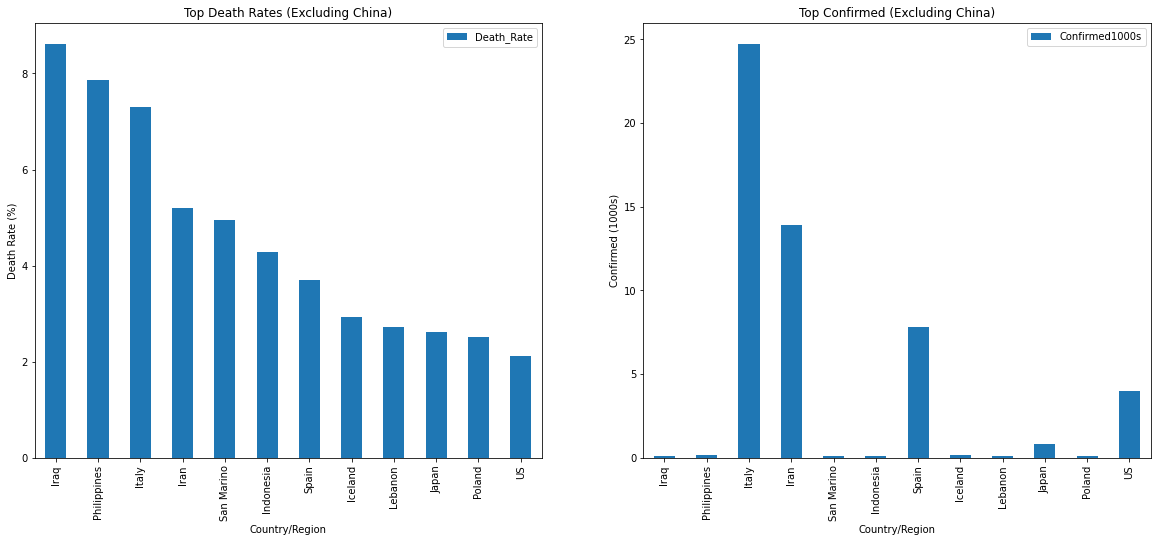

In [11]:
top_countries = totals.head(12)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax1.set_ylabel('Death Rate (%)')
ax2.set_ylabel('Confirmed (1000s)')
top_countries[['Death_Rate']].plot(kind='bar', title='Top Death Rates (Excluding China)', ax=ax1)
top_countries[['Confirmed1000s']].plot(kind='bar', title='Top Confirmed (Excluding China)', ax=ax2)
top_countries = top_countries.index.values
plt.show()

In [12]:
affected_df = affected_df.set_index('Country/Region')

In [13]:
top_countries_dfs = []
top_countries_recovered_dfs = []
top_countries_confirmed_growth_dfs = []
top_countries_daily_confirmed_dfs = []
for country in top_countries:
    country_sums = affected_df.loc[country]
    dates = country_sums['Date']
    country_daily = affected_df.loc[country].copy()
    country_sums = country_sums[['Deaths', 'Confirmed', 'Recovered']].cumsum()
    country_sums['Death_Rate'] = country_sums.Deaths / country_sums.Confirmed * 100
    country_sums['Recovery_Rate'] = country_sums.Recovered / country_sums.Confirmed * 100
    country_sums['Date'] = dates
    
    country_daily = country_daily[['Confirmed', 'Date']]
    country_confirmed = country_sums[['Confirmed', 'Date']]
    country_rr = country_sums[['Recovery_Rate', 'Date']]
    country_dr = country_sums[['Death_Rate', 'Date']]
    
    country_daily = country_daily.reset_index().drop(columns=['Country/Region'])
    country_confirmed = country_confirmed.reset_index().drop(columns=['Country/Region'])
    country_rr = country_rr.reset_index().drop(columns=['Country/Region'])
    country_dr = country_dr.reset_index().drop(columns=['Country/Region'])
    
    country_daily = country_daily.rename(columns={'Confirmed': country, 'Date': country + '_Date'})
    country_confirmed = country_confirmed.rename(columns={'Confirmed': country, 'Date': country + '_Date'})
    country_rr = country_rr.rename(columns={'Recovery_Rate': country, 'Date': country + '_Date'})
    country_dr = country_dr.rename(columns={'Death_Rate': country, 'Date': country + '_Date'})
    
    top_countries_daily_confirmed_dfs.append(country_daily)
    top_countries_recovered_dfs.append(country_rr)
    top_countries_confirmed_growth_dfs.append(country_confirmed) 
    top_countries_dfs.append(country_dr)


### Death Rate Progression

This shows the death rate progression since the first reported case in each country. Said another way, the 
x axis is the number of days since each country had a reported confirmed case in each individual country 
so that the days of progression are aligned to compare progression.

In [14]:
country_dr = pd.concat(top_countries_dfs, axis=1, join='outer')
country_dr

,Iraq,Iraq_Date,Philippines,Philippines_Date,Italy,Italy_Date,Iran,Iran_Date,San Marino,San Marino_Date,...,Iceland,Iceland_Date,Lebanon,Lebanon_Date,Japan,Japan_Date,Poland,Poland_Date,US,US_Date
0,0.000000,2020-02-24,0.000000,2020-01-30,0.000000,2020-01-31,100.000000,2020-02-19,0.000000,2020-02-27,...,0.000000,2020-02-28,0.000000,2020-02-21,0.000000,2020-01-22,0.000000,2020-03-04,0.000000,2020-01-22
1,0.000000,2020-02-25,0.000000,2020-01-31,0.000000,2020-02-01,40.000000,2020-02-20,0.000000,2020-02-28,...,0.000000,2020-02-29,0.000000,2020-02-22,0.000000,2020-01-23,0.000000,2020-03-05,0.000000,2020-01-23
2,0.000000,2020-02-26,0.000000,2020-02-01,0.000000,2020-02-02,22.222222,2020-02-21,0.000000,2020-02-29,...,0.000000,2020-03-01,0.000000,2020-02-23,0.000000,2020-01-24,0.000000,2020-03-06,0.000000,2020-01-24
3,0.000000,2020-02-27,50.000000,2020-02-02,0.000000,2020-02-03,17.857143,2020-02-22,0.000000,2020-03-01,...,0.000000,2020-03-02,0.000000,2020-02-24,0.000000,2020-01-25,0.000000,2020-03-07,0.000000,2020-01-25
4,0.000000,2020-02-28,50.000000,2020-02-03,0.000000,2020-02-04,18.604651,2020-02-23,0.000000,2020-03-02,...,0.000000,2020-03-03,0.000000,2020-02-25,0.000000,2020-01-26,0.000000,2020-03-08,0.000000,2020-01-26
5,0.000000,2020-02-29,50.000000,2020-02-04,0.000000,2020-02-05,19.672131,2020-02-24,10.000000,2020-03-03,...,0.000000,2020-03-04,0.000000,2020-02-26,0.000000,2020-01-27,0.000000,2020-03-09,0.000000,2020-01-27
6,0.000000,2020-03-01,50.000000,2020-02-05,0.000000,2020-02-06,16.842105,2020-02-25,6.250000,2020-03-04,...,0.000000,2020-03-05,0.000000,2020-02-27,0.000000,2020-01-28,0.000000,2020-03-10,0.000000,2020-01-28
7,0.000000,2020-03-02,50.000000,2020-02-06,0.000000,2020-02-07,13.669065,2020-02-26,4.761905,2020-03-05,...,0.000000,2020-03-06,0.000000,2020-02-28,0.000000,2020-01-29,0.000000,2020-03-11,0.000000,2020-01-29
8,0.000000,2020-03-03,33.333333,2020-02-07,0.000000,2020-02-08,10.612245,2020-02-27,4.761905,2020-03-06,...,0.000000,2020-03-07,0.000000,2020-02-29,0.000000,2020-01-30,2.040816,2020-03-12,0.000000,2020-01-30
9,5.714286,2020-03-04,33.333333,2020-02-08,0.000000,2020-02-09,8.762887,2020-02-28,4.347826,2020-03-07,...,0.000000,2020-03-08,0.000000,2020-03-01,0.000000,2020-01-31,2.941176,2020-03-13,0.000000,2020-01-31


In [15]:
create_download_link(country_dr, title='Death Rate Progression Download', filename='death_rate_progression.csv')

In [16]:
non_date_cols = [col for col in country_dr if not col.endswith('_Date')]
country_dr = country_dr[non_date_cols]
linewidth = 4

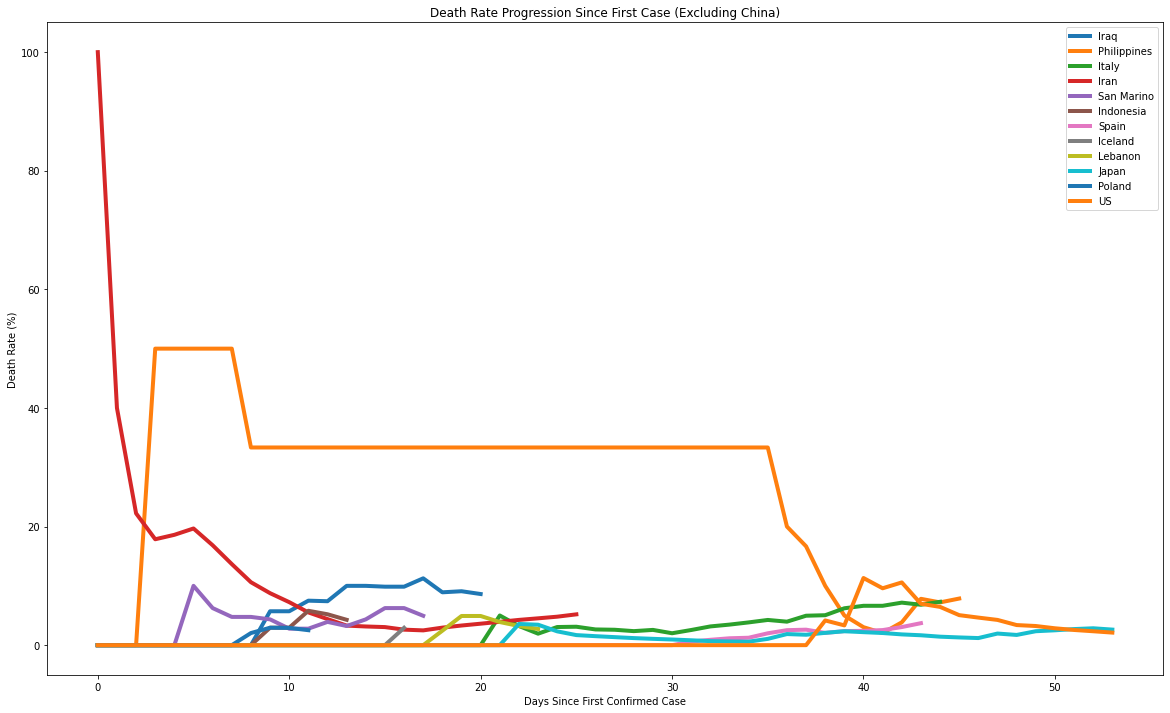

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,12))
ax.set_ylabel('Death Rate (%)')
ax.set_xlabel('Days Since First Confirmed Case')
country_dr.plot(ax=ax, linewidth=linewidth, title='Death Rate Progression Since First Case (Excluding China)')
plt.show()

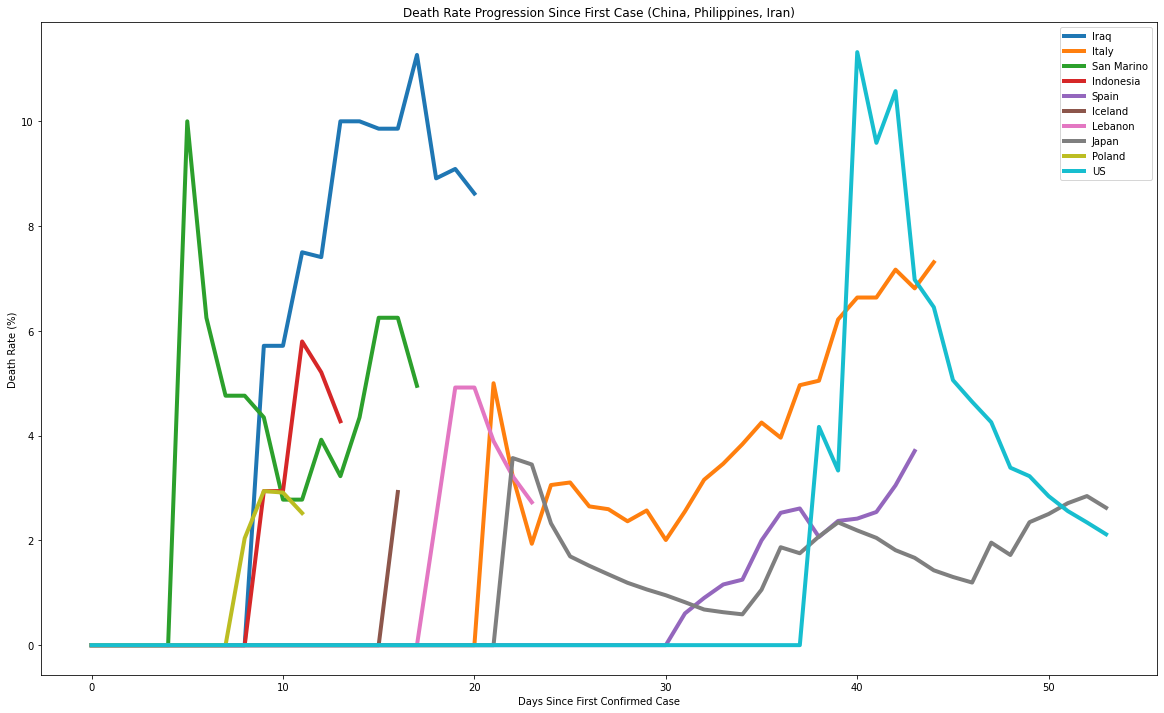

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,12))
ax.set_ylabel('Death Rate (%)')
ax.set_xlabel('Days Since First Confirmed Case')
country_dr[countries].plot(ax=ax, linewidth=linewidth, title='Death Rate Progression Since First Case (' + exclude_str + ')')
plt.show()

### Recovery Rate

In [20]:
country_rr = pd.concat(top_countries_recovered_dfs, axis=1, join='outer')
country_rr

,Iraq,Iraq_Date,Philippines,Philippines_Date,Italy,Italy_Date,Iran,Iran_Date,San Marino,San Marino_Date,...,Iceland,Iceland_Date,Lebanon,Lebanon_Date,Japan,Japan_Date,Poland,Poland_Date,US,US_Date
0,0.000000,2020-02-24,0.000000,2020-01-30,0.000000,2020-01-31,0.000000,2020-02-19,0.000000,2020-02-27,...,0.000000,2020-02-28,0.000000,2020-02-21,0.000000,2020-01-22,0.0,2020-03-04,0.000000,2020-01-22
1,0.000000,2020-02-25,0.000000,2020-01-31,0.000000,2020-02-01,0.000000,2020-02-20,0.000000,2020-02-28,...,0.000000,2020-02-29,0.000000,2020-02-22,0.000000,2020-01-23,0.0,2020-03-05,0.000000,2020-01-23
2,0.000000,2020-02-26,0.000000,2020-02-01,0.000000,2020-02-02,0.000000,2020-02-21,0.000000,2020-02-29,...,0.000000,2020-03-01,0.000000,2020-02-23,0.000000,2020-01-24,0.0,2020-03-06,0.000000,2020-01-24
3,0.000000,2020-02-27,0.000000,2020-02-02,0.000000,2020-02-03,0.000000,2020-02-22,0.000000,2020-03-01,...,0.000000,2020-03-02,0.000000,2020-02-24,0.000000,2020-01-25,0.0,2020-03-07,0.000000,2020-01-25
4,0.000000,2020-02-28,0.000000,2020-02-03,0.000000,2020-02-04,0.000000,2020-02-23,0.000000,2020-03-02,...,0.000000,2020-03-03,0.000000,2020-02-25,25.000000,2020-01-26,0.0,2020-03-08,0.000000,2020-01-26
5,0.000000,2020-02-29,0.000000,2020-02-04,0.000000,2020-02-05,0.000000,2020-02-24,0.000000,2020-03-03,...,0.000000,2020-03-04,0.000000,2020-02-26,25.000000,2020-01-27,0.0,2020-03-09,0.000000,2020-01-27
6,0.000000,2020-03-01,0.000000,2020-02-05,0.000000,2020-02-06,0.000000,2020-02-25,0.000000,2020-03-04,...,0.000000,2020-03-05,0.000000,2020-02-27,14.285714,2020-01-28,0.0,2020-03-10,0.000000,2020-01-28
7,0.000000,2020-03-02,0.000000,2020-02-06,0.000000,2020-02-07,35.251799,2020-02-26,0.000000,2020-03-05,...,0.000000,2020-03-06,0.000000,2020-02-28,14.285714,2020-01-29,0.0,2020-03-11,0.000000,2020-01-29
8,0.000000,2020-03-03,0.000000,2020-02-07,0.000000,2020-02-08,20.000000,2020-02-27,0.000000,2020-03-06,...,0.000000,2020-03-07,0.000000,2020-02-29,9.090909,2020-01-30,0.0,2020-03-12,0.000000,2020-01-30
9,0.000000,2020-03-04,0.000000,2020-02-08,0.000000,2020-02-09,18.814433,2020-02-28,0.000000,2020-03-07,...,0.000000,2020-03-08,0.000000,2020-03-01,6.666667,2020-01-31,0.0,2020-03-13,0.000000,2020-01-31


In [21]:
create_download_link(country_rr, title='Recovery Rate Download', filename='recovery.csv')

In [22]:
country_rr = country_rr[non_date_cols]

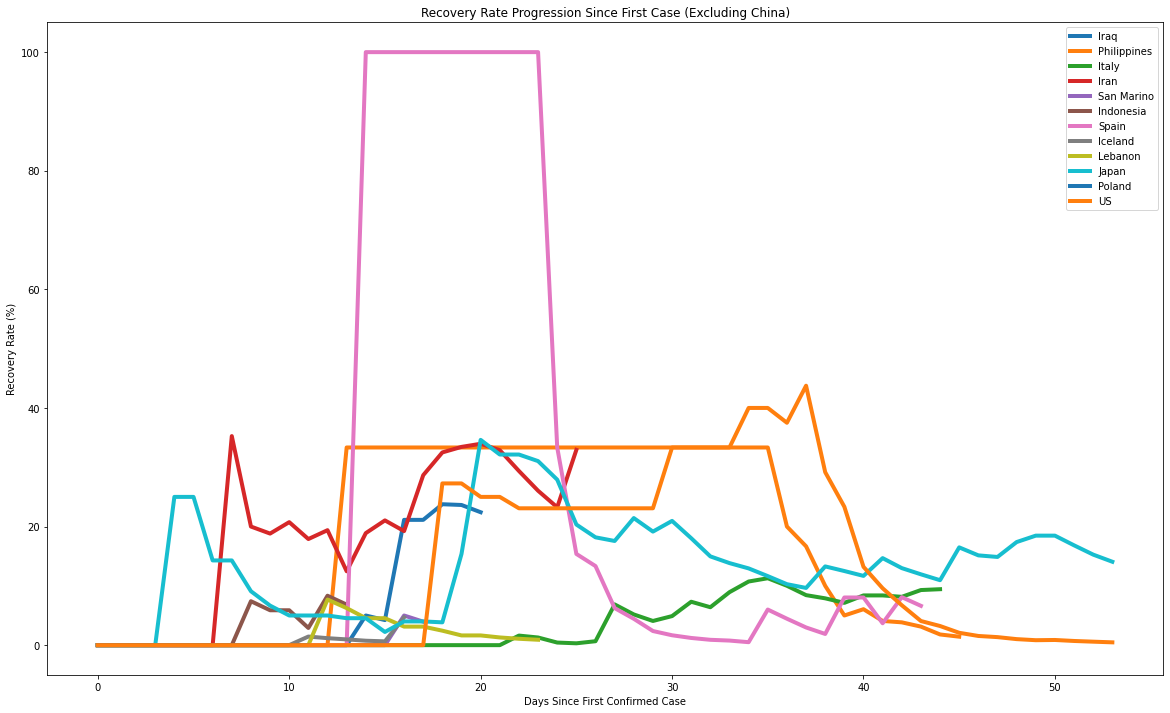

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,12))
ax.set_ylabel('Recovery Rate (%)')
ax.set_xlabel('Days Since First Confirmed Case')
country_rr.plot(ax=ax, linewidth=linewidth, title='Recovery Rate Progression Since First Case (Excluding China)')
plt.show()

### Confirmed Case Growth (Cummalative Sum of Total Confirmed)

In [24]:
country_confirmed = pd.concat(top_countries_confirmed_growth_dfs, axis=1, join='outer')
country_confirmed

,Iraq,Iraq_Date,Philippines,Philippines_Date,Italy,Italy_Date,Iran,Iran_Date,San Marino,San Marino_Date,...,Iceland,Iceland_Date,Lebanon,Lebanon_Date,Japan,Japan_Date,Poland,Poland_Date,US,US_Date
0,1.0,2020-02-24,1.0,2020-01-30,2.0,2020-01-31,2.0,2020-02-19,1.0,2020-02-27,...,1.0,2020-02-28,1.0,2020-02-21,2,2020-01-22,1.0,2020-03-04,1,2020-01-22
1,1.0,2020-02-25,1.0,2020-01-31,2.0,2020-02-01,5.0,2020-02-20,1.0,2020-02-28,...,1.0,2020-02-29,1.0,2020-02-22,1,2020-01-23,1.0,2020-03-05,1,2020-01-23
2,5.0,2020-02-26,1.0,2020-02-01,2.0,2020-02-02,18.0,2020-02-21,1.0,2020-02-29,...,3.0,2020-03-01,1.0,2020-02-23,2,2020-01-24,5.0,2020-03-06,2,2020-01-24
3,7.0,2020-02-27,2.0,2020-02-02,2.0,2020-02-03,28.0,2020-02-22,1.0,2020-03-01,...,6.0,2020-03-02,1.0,2020-02-24,2,2020-01-25,5.0,2020-03-07,2,2020-01-25
4,7.0,2020-02-28,2.0,2020-02-03,2.0,2020-02-04,43.0,2020-02-23,8.0,2020-03-02,...,11.0,2020-03-03,1.0,2020-02-25,4,2020-01-26,11.0,2020-03-08,5,2020-01-26
5,13.0,2020-02-29,2.0,2020-02-04,2.0,2020-02-05,61.0,2020-02-24,10.0,2020-03-03,...,26.0,2020-03-04,2.0,2020-02-26,4,2020-01-27,16.0,2020-03-09,5,2020-01-27
6,19.0,2020-03-01,2.0,2020-02-05,2.0,2020-02-06,95.0,2020-02-25,16.0,2020-03-04,...,34.0,2020-03-05,2.0,2020-02-27,7,2020-01-28,22.0,2020-03-10,5,2020-01-28
7,26.0,2020-03-02,2.0,2020-02-06,3.0,2020-02-07,139.0,2020-02-26,21.0,2020-03-05,...,43.0,2020-03-06,2.0,2020-02-28,7,2020-01-29,31.0,2020-03-11,5,2020-01-29
8,32.0,2020-03-03,3.0,2020-02-07,3.0,2020-02-08,245.0,2020-02-27,21.0,2020-03-06,...,50.0,2020-03-07,4.0,2020-02-29,11,2020-01-30,49.0,2020-03-12,5,2020-01-30
9,35.0,2020-03-04,3.0,2020-02-08,3.0,2020-02-09,388.0,2020-02-28,23.0,2020-03-07,...,50.0,2020-03-08,10.0,2020-03-01,15,2020-01-31,68.0,2020-03-13,7,2020-01-31


In [25]:
create_download_link(country_daily, title='Cummulative Confirmed Cases Download', filename='cummative_growth.csv')

In [26]:
country_confirmed = country_confirmed[non_date_cols]

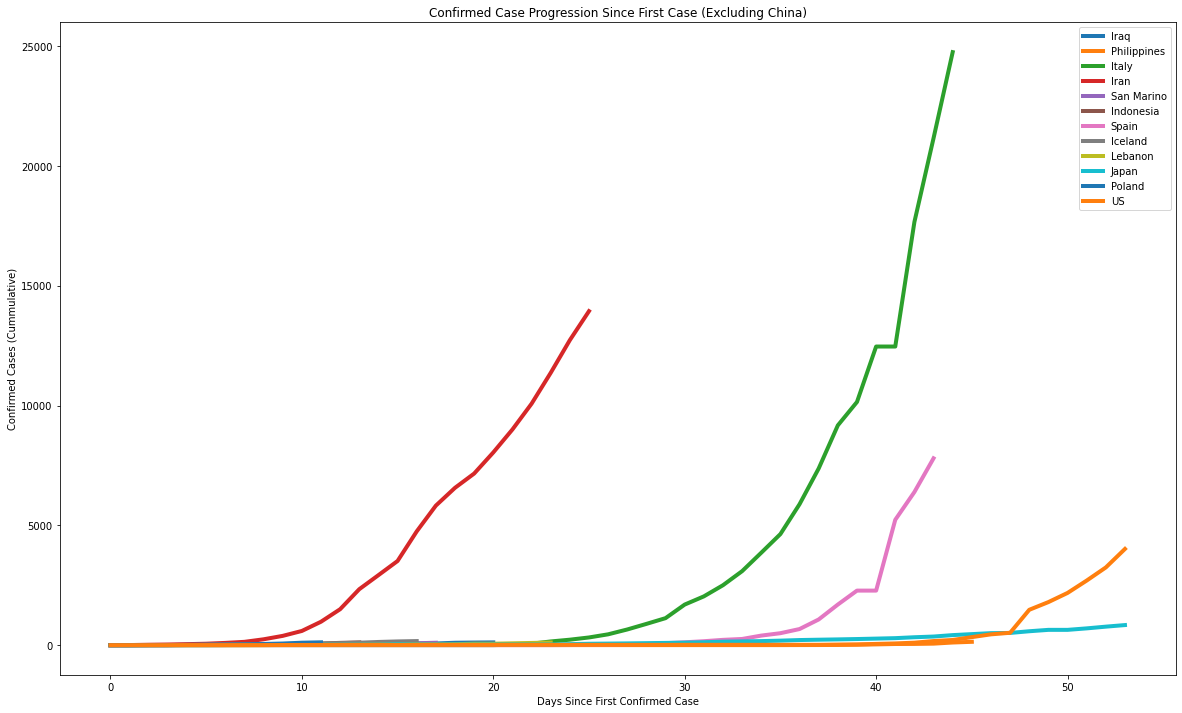

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,12))
ax.set_ylabel('Confirmed Cases (Cummulative)')
ax.set_xlabel('Days Since First Confirmed Case')
country_confirmed.plot(ax=ax, linewidth=linewidth, title='Confirmed Case Progression Since First Case (Excluding China)')
plt.show()

In [28]:
exclude_countries = ['China', 'Italy', 'Iran', 'Spain', 'Philippines']
countries = []
for col in country_confirmed.columns:
    parts = col.split('_')
    country = parts[0]
    if country not in exclude_countries:
        countries.append(country)
countries

['Iraq',
 'San Marino',
 'Indonesia',
 'Iceland',
 'Lebanon',
 'Japan',
 'Poland',
 'US']

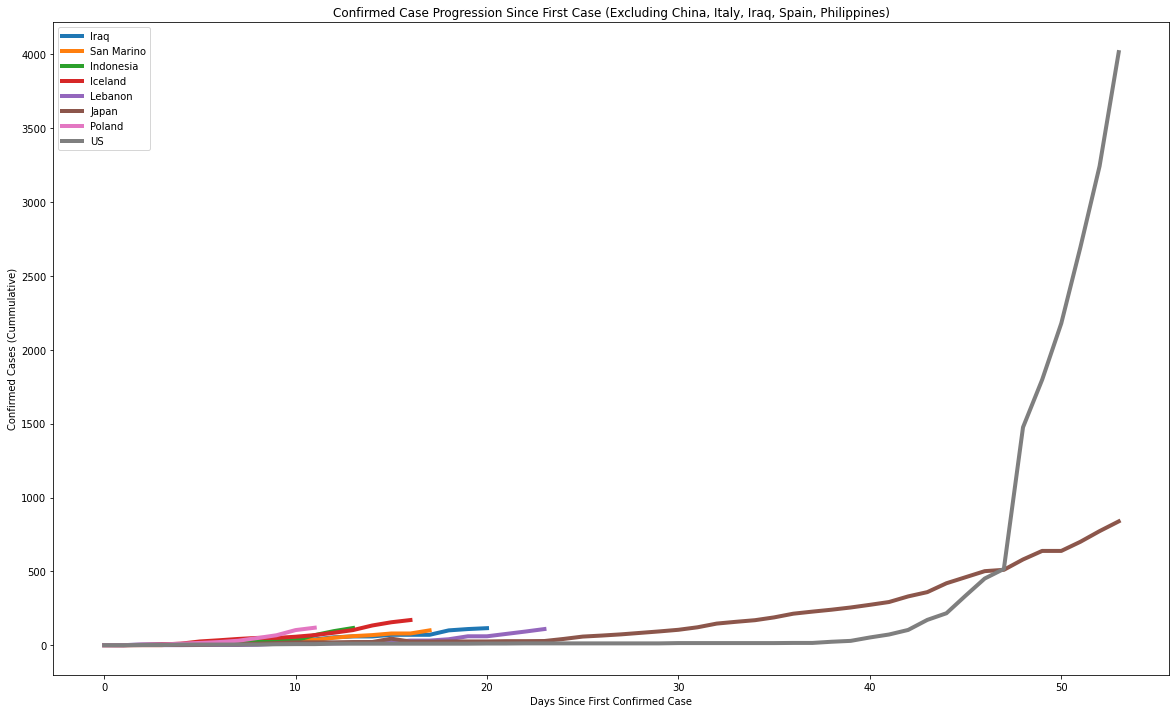

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,12))
ax.set_ylabel('Confirmed Cases (Cummulative)')
ax.set_xlabel('Days Since First Confirmed Case')
country_confirmed[countries].plot(ax=ax, linewidth=linewidth, title='Confirmed Case Progression Since First Case (Excluding China, Italy, Iraq, Spain, Philippines)')
plt.show()

### Confirmed Case Growth (New Cases Daily)

In [30]:
country_daily = pd.concat(top_countries_daily_confirmed_dfs, axis=1, join='outer')
country_daily

,Iraq,Iraq_Date,Philippines,Philippines_Date,Italy,Italy_Date,Iran,Iran_Date,San Marino,San Marino_Date,...,Iceland,Iceland_Date,Lebanon,Lebanon_Date,Japan,Japan_Date,Poland,Poland_Date,US,US_Date
0,1.0,2020-02-24,1.0,2020-01-30,2.0,2020-01-31,2.0,2020-02-19,1.0,2020-02-27,...,1.0,2020-02-28,1.0,2020-02-21,2,2020-01-22,1.0,2020-03-04,1,2020-01-22
1,0.0,2020-02-25,0.0,2020-01-31,0.0,2020-02-01,3.0,2020-02-20,0.0,2020-02-28,...,0.0,2020-02-29,0.0,2020-02-22,-1,2020-01-23,0.0,2020-03-05,0,2020-01-23
2,4.0,2020-02-26,0.0,2020-02-01,0.0,2020-02-02,13.0,2020-02-21,0.0,2020-02-29,...,2.0,2020-03-01,0.0,2020-02-23,1,2020-01-24,4.0,2020-03-06,1,2020-01-24
3,2.0,2020-02-27,1.0,2020-02-02,0.0,2020-02-03,10.0,2020-02-22,0.0,2020-03-01,...,3.0,2020-03-02,0.0,2020-02-24,0,2020-01-25,0.0,2020-03-07,0,2020-01-25
4,0.0,2020-02-28,0.0,2020-02-03,0.0,2020-02-04,15.0,2020-02-23,7.0,2020-03-02,...,5.0,2020-03-03,0.0,2020-02-25,2,2020-01-26,6.0,2020-03-08,3,2020-01-26
5,6.0,2020-02-29,0.0,2020-02-04,0.0,2020-02-05,18.0,2020-02-24,2.0,2020-03-03,...,15.0,2020-03-04,1.0,2020-02-26,0,2020-01-27,5.0,2020-03-09,0,2020-01-27
6,6.0,2020-03-01,0.0,2020-02-05,0.0,2020-02-06,34.0,2020-02-25,6.0,2020-03-04,...,8.0,2020-03-05,0.0,2020-02-27,3,2020-01-28,6.0,2020-03-10,0,2020-01-28
7,7.0,2020-03-02,0.0,2020-02-06,1.0,2020-02-07,44.0,2020-02-26,5.0,2020-03-05,...,9.0,2020-03-06,0.0,2020-02-28,0,2020-01-29,9.0,2020-03-11,0,2020-01-29
8,6.0,2020-03-03,1.0,2020-02-07,0.0,2020-02-08,106.0,2020-02-27,0.0,2020-03-06,...,7.0,2020-03-07,2.0,2020-02-29,4,2020-01-30,18.0,2020-03-12,0,2020-01-30
9,3.0,2020-03-04,0.0,2020-02-08,0.0,2020-02-09,143.0,2020-02-28,2.0,2020-03-07,...,0.0,2020-03-08,6.0,2020-03-01,4,2020-01-31,19.0,2020-03-13,2,2020-01-31


In [31]:
create_download_link(country_daily, title='Daily Cases Since First Occurrence Download', filename='daily_cases_since_first.csv')

In [32]:
country_daily = country_daily[non_date_cols]

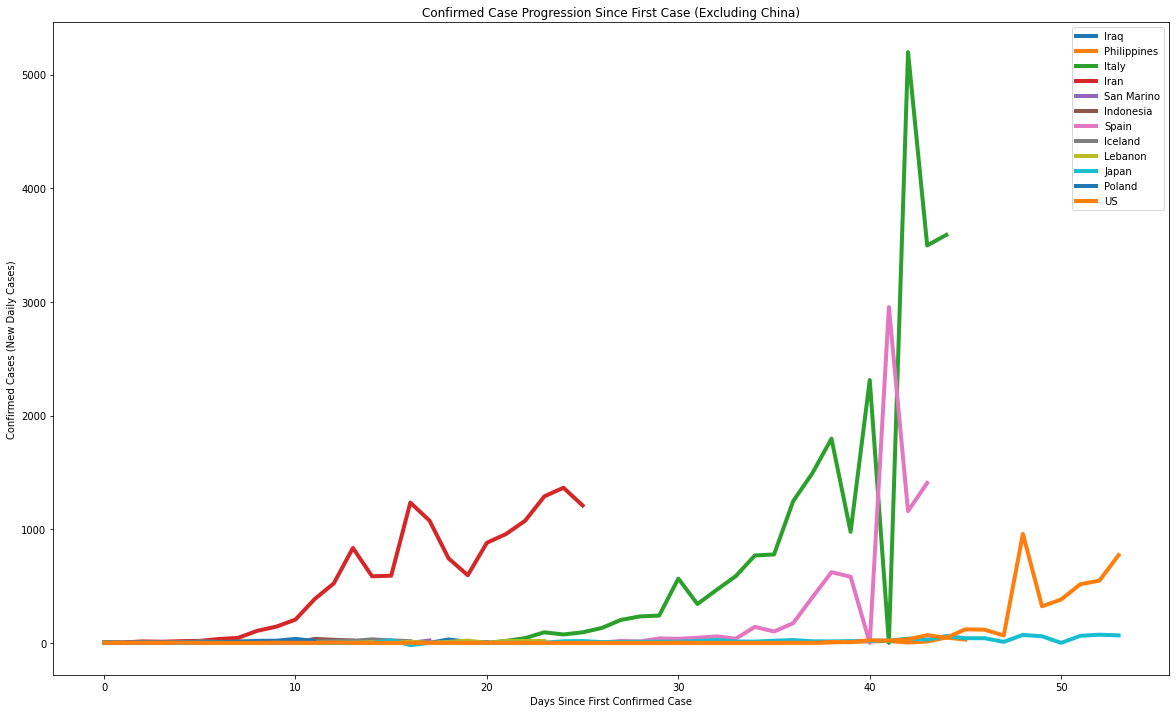

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,12))
ax.set_ylabel('Confirmed Cases (New Daily Cases)')
ax.set_xlabel('Days Since First Confirmed Case')
country_daily.plot(ax=ax, linewidth=linewidth, title='Confirmed Case Progression Since First Case (Excluding China)')
plt.show()